# Import Libraries & Setup

In [4]:
"""
Word2Vec Similarity System

This script builds a Word2Vec model from the Reuters Corpus, finds similar words for given inputs,
and visualizes word embeddings in 2D using t-SNE. It includes robust error handling, logging,
and professional output formatting for analytical insights.
"""
# Install Required Libraries
# !pip install -q gensim

# Import Libraries
import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import logging
import warnings
from typing import List, Dict, Tuple, Optional
from collections import Counter

# Setup Logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s",
                    handlers=[
                        logging.FileHandler("word2vec.log"),
                        logging.StreamHandler()
                    ])
logger = logging.getLogger(__name__)

# Setup Warnings
warnings.filterwarnings("ignore")


# Word2Vec Class

2025-04-12 16:36:03,522 - INFO - Loaded and tokenized 1000 documents
2025-04-12 16:36:03,539 - INFO - Corpus stats: {'total_words': 141771, 'unique_words': 13283, 'most_common': [('the', 6028), (',', 4931), ('.', 4411), ('of', 3278), ('to', 3050), ('in', 2584), ('and', 2275), ('said', 2222), ('a', 2032), ('mln', 1844)]}
2025-04-12 16:36:03,542 - INFO - collecting all words and their counts
2025-04-12 16:36:03,543 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-04-12 16:36:03,559 - INFO - collected 13283 word types from a corpus of 141771 raw words and 1000 sentences
2025-04-12 16:36:03,560 - INFO - Creating a fresh vocabulary
2025-04-12 16:36:03,574 - INFO - Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2933 unique words (22.08% of original 13283, drops 10350)', 'datetime': '2025-04-12T16:36:03.574071', 'gensim': '4.3.3', 'python': '3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]', 'platf


Similarity Report:
Input Word                                                                                Similar Words  In Vocabulary
    market            temporary (0.676), buying (0.673), liquidity (0.672), money (0.666), main (0.649)           True
     stock     two-for-one (0.783), split (0.766), preferred (0.764), ownership (0.751), common (0.738)           True
     trade      deficit (0.704), official (0.687), surplus (0.677), budget (0.675), merchandise (0.671)           True
   economy stimulate (0.869), slow (0.868), expansion (0.849), employment (0.843), protectionist (0.84)           True
      bank             england (0.66), central (0.618), governor (0.61), dollars (0.609), swiss (0.602)           True


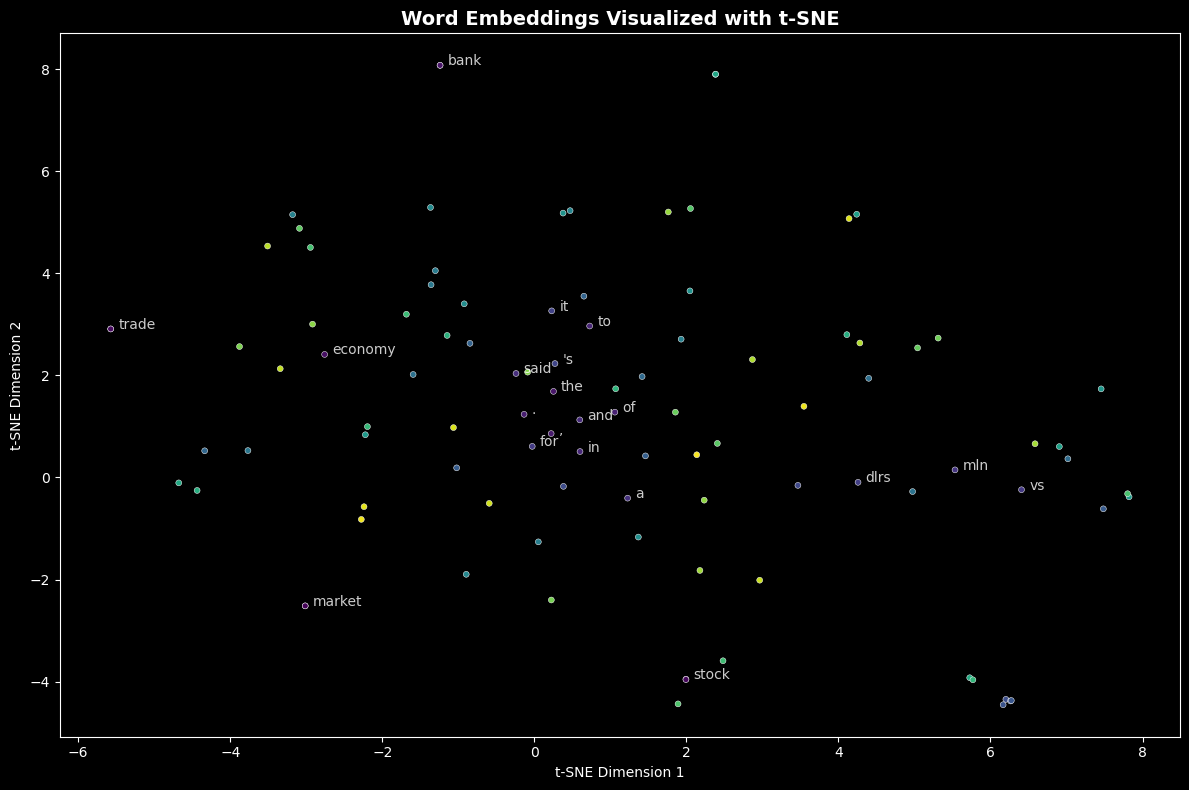

2025-04-12 16:36:06,275 - INFO - Embedding visualization saved


In [5]:
class Word2VecSimilaritySystem:
    """A system to build Word2Vec models, find similar words, and visualize embeddings."""

    def __init__(
            self,
            corpus_name: str = "reuters",
            max_docs: int = 1000,
            vector_size: int = 100,
            window: int = 5,
            min_count: int = 5,
            sg: int = 1,
            epochs: int = 10,
            workers: int = 10
    ):
        """
        Initialize the system with corpus and Word2Vec parameters.

        Args:
            corpus_name (str): Name of the NLTK corpus (default: 'reuters').
            max_docs (int): Maximum number of documents to process (default: 1000).
            vector_size (int): Dimension of word vectors (default: 100).
            window (int): Context window size (default: 5).
            min_count (int): Minimum word frequency (default: 5).
            sg (int): 1 for Skip-gram, 0 for CBOW (default: 1).
            epochs (int): Number of training epochs (default: 10).
        """
        self.corpus_name = corpus_name
        self.max_docs = max_docs
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.epochs = epochs
        self.model = None
        self.corpus = []
        self.tokenized_corpus = []
        self.vocab_stats = {}

        try:
            nltk.download("punkt", quiet=True)
            nltk.download("punkt_tab", quiet=True)
            nltk.download("reuters", quiet=True)
        except Exception as e:
            logging.error(f"Failed to download NLTK Resources {e}")
            raise e

    def load_corpus(self) -> None:
        """Load and preprocess the corpus."""
        try:
            if self.corpus_name == "reuters":
                fileids = reuters.fileids()[:self.max_docs]
                self.corpus = [reuters.raw(fileid) for fileid in fileids]
            else:
                raise ValueError(f"Unsupported corpus: {self.corpus_name}")

            self.tokenized_corpus = [
                word_tokenize(doc.lower()) for doc in self.corpus
            ]
            logger.info(f"Loaded and tokenized {len(self.corpus)} documents")

            # Compute vocabulary statistics
            all_words = [word for doc in self.tokenized_corpus for word in doc]
            word_counts = Counter(all_words)
            self.vocab_stats = {
                "total_words": len(all_words),
                "unique_words": len(word_counts),
                "most_common": word_counts.most_common(10)
            }
            logger.info(f"Corpus stats: {self.vocab_stats}")
        except Exception as e:
            logger.error(f"Corpus loading error: {e}")
            raise e

    def train_model(self) -> None:
        """Train the Word2Vec model."""
        try:
            self.model = Word2Vec(
                sentences=self.tokenized_corpus,
                vector_size=self.vector_size,
                window=self.window,
                min_count=self.min_count,
                sg=self.sg,
                epochs=self.epochs,
                workers=4,  # Parallel processing
                seed=42
            )
            logger.info("Word2Vec model trained successfully")
        except Exception as e:
            logger.error(f"Model training error: {e}")
            raise

    def find_similar_words(self, word: str, topn: int = 5) -> List[Tuple[str, float]]:
        """
        Find top similar words for a given word.

        Args:
            word (str): Input word.
            topn (int): Number of similar words to return (default: 5).

        Returns:
            List[Tuple[str, float]]: List of (word, similarity_score) tuples.
        """
        try:
            if not self.model:
                raise ValueError("Model not trained")
            if word not in self.model.wv:
                logger.warning(f"Word '{word}' not in vocabulary")
                return []
            similar_words = self.model.wv.most_similar(word, topn=topn)
            logger.info(f"Found {len(similar_words)} similar words for '{word}'")
            return similar_words
        except Exception as e:
            logger.error(f"Similarity search error for '{word}': {e}")
            return []

    def visualize_embeddings(
        self,
        output_dir: str = "output",
        num_words: int = 100,
        sample_words: Optional[List[str]] = None
    ) -> None:
        """
        Visualize word embeddings in 2D using t-SNE.

        Args:
            output_dir (str): Directory to save visualization (default: 'output').
            num_words (int): Number of words to visualize (default: 100).
            sample_words (Optional[List[str]]): Specific words to include (default: None).
        """
        try:
            if not self.model:
                raise ValueError("Model not trained")

            # Select words to visualize
            vocab = list(self.model.wv.key_to_index.keys())
            if sample_words:
                valid_words = [w for w in sample_words if w in vocab]
                vocab = valid_words + vocab
            words = vocab[:num_words]
            vectors = np.array([self.model.wv[word] for word in words])

            # Apply t-SNE
            tsne = TSNE(
                n_components=2,
                random_state=42,
                perplexity=min(30, len(words) - 1),
                n_iter=1000
            )
            vectors_2d = tsne.fit_transform(vectors)

            # Create DataFrame for visualization
            df = pd.DataFrame({
                "word": words,
                "x": vectors_2d[:, 0],
                "y": vectors_2d[:, 1]
            })

            # Plot
            plt.figure(figsize=(12, 8))
            sns.scatterplot(
                data=df,
                x="x",
                y="y",
                hue="word",
                size=2,
                legend=False,
                palette="viridis"
            )

            # Annotate a subset of words to avoid clutter
            for _, row in df.head(20).iterrows():
                plt.text(
                    row["x"] + 0.1,
                    row["y"],
                    row["word"],
                    fontsize=10,
                    alpha=0.8
                )

            plt.title("Word Embeddings Visualized with t-SNE", fontsize=14, fontweight="bold")
            plt.xlabel("t-SNE Dimension 1")
            plt.ylabel("t-SNE Dimension 2")
            plt.tight_layout()

            # Save plot
            Path(output_dir).mkdir(exist_ok=True)
            plt.savefig(f"{output_dir}/word_embeddings_tsne.png", dpi=300)
            plt.show()
            logger.info("Embedding visualization saved")
        except Exception as e:
            logger.error(f"Visualization error: {e}")
            raise e

    def generate_report(self, test_words: List[str], output_dir: str = "output") -> pd.DataFrame:
        """
        Generate a report with similar words and corpus statistics.

        Args:
            test_words (List[str]): List of words to find similarities for.
            output_dir (str): Directory to save report (default: 'output').

        Returns:
            pd.DataFrame: Report DataFrame.
        """
        try:
            data = []
            for word in test_words:
                similar_words = self.find_similar_words(word)
                data.append({
                    "Input Word": word,
                    "Similar Words": ", ".join([f"{w} ({round(s, 3)})" for w, s in similar_words]),
                    "In Vocabulary": word in self.model.wv
                })

            df = pd.DataFrame(data)

            # Add corpus stats to log
            stats_df = pd.DataFrame([{
                "Total Words": self.vocab_stats["total_words"],
                "Unique Words": self.vocab_stats["unique_words"],
                "Top 5 Words": ", ".join([f"{w} ({c})" for w, c in self.vocab_stats["most_common"][:5]])
            }])

            # Save report
            Path(output_dir).mkdir(exist_ok=True)
            report_path = f"{output_dir}/similarity_report.csv"
            df.to_csv(report_path, index=False)
            stats_path = f"{output_dir}/corpus_stats.csv"
            stats_df.to_csv(stats_path, index=False)

            logger.info(f"Report saved to {report_path}")
            logger.info(f"Stats saved to {stats_path}")
            return df
        except Exception as e:
            logger.error(f"Report generation error: {e}")
            raise e

def main():
    """Main function to execute the Word2Vec similarity system."""
    try:
        # Initialize system
        system = Word2VecSimilaritySystem(
            max_docs=1000,
            vector_size=100,
            window=5,
            min_count=5,
            sg=1,
            epochs=10
        )

        # Load and preprocess corpus
        system.load_corpus()

        # Train model
        system.train_model()

        # Test words for similarity
        test_words = ["market", "stock", "trade", "economy", "bank"]

        # Generate report
        report_df = system.generate_report(test_words)
        print("\nSimilarity Report:")
        print(report_df.to_string(index=False))

        # Visualize embeddings
        system.visualize_embeddings(
            sample_words=test_words,
            num_words=100
        )

    except Exception as e:
        logger.error(f"Main execution error: {e}")


main()